# FPP multi objective optimization

### Setup distributed computing environment

See more details here: https://fuse.help/parallel.html

In [1]:
if gethostname() == "saga.cluster"
    nodes = 4
    np = 30 * nodes
    using Pkg
    Pkg.activate("..")
    using Distributed
    using ClusterManagers
    ENV["JULIA_WORKER_TIMEOUT"] = "180"
    if nprocs() < np
        addprocs(SlurmManager(np - nprocs()), exclusive="", topology=:master_worker)
    end
else
    using Distributed
    np = 4
    if nprocs() < np + 1
        addprocs(np - nprocs() + 1, topology=:master_worker)
    end
end
println("Working with $(nprocs()) processes")

Working with 5 processes


### Import packages

In [2]:
using Revise
using FUSE
using Plots;
gr();
FUSE.logging(Logging.Info; actors=Logging.Error);

┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1664


WebIO._IJuliaInit()

### Get `ini` and `act` for FPP case and custmize as needed

In [3]:
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:scalars)
act.ActorTauenn.transport_model=:ds03
act.ActorTauenn.confinement_factor=1.5
act.ActorPFcoilsOpt.optimization_scheme = :none; # don't spend time optimizing the PFs

### As a good practice, test the actor/workflow that you want to optimize first

In [4]:
dd = FUSE.init(ini, act)
FUSE.ActorWholeFacility(dd, act);

┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393


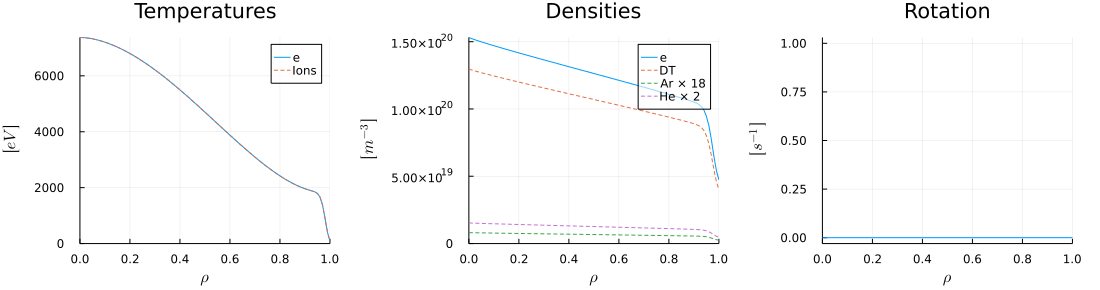

In [5]:
#IMAS.freeze(dd.balance_of_plant)
plot(dd.core_profiles)

### Define optimization variables and ranges

In [6]:
# nominal value and ranges
ini.core_profiles.zeff = 2.0 ↔ [1.1, 2.5]
ini.core_profiles.greenwald_fraction = 0.9 ↔ [0.8, 0.95]
ini.ec_launchers.power_launched = 45e6 ↔ [20e6, 60e6];

### Define the optimization objectives

In [7]:
# FUSE comes with a library of objective functions
OFL = FUSE.ObjectivesFunctionsLibrary
objective_functions = [OFL[:max_power_electric_net], OFL[:min_levelized_CoE], OFL[:max_log10_flattop]]

# ...but one can define custom optimization objectives too
# target_power_electric = FUSE.ObjectiveFunction(:target_power_electric_net, "MW", dd -> @ddtime(dd.balance_of_plant.power_electric_net)/1E6, 200)
# objective_functions = [target_power_electric, OFL[:min_cost], OFL[:max_flattop]]

3-element Vector{FUSE.ObjectiveFunction}:
 max_power_electric_net [MW]
 min_cost [$M]
 max_log10_flattop [log₁₀(hours)]

### Setup and run optimization

In [8]:
# option to resume an optimization where it was left off
if true
    continue_results = missing
else
    continue_results = results
end

# define optimization parameters
# For real optimization studies the population size (N) and number of iterations should be bigger
# eg. N=100, iterations=25
optimization_parameters = Dict(
    :N => max(4, Int(floor((nprocs()-1)/2))*2), # even number
    :iterations => 10,
    :continue_results => continue_results)

# run optimization
results = FUSE.workflow_multiobjective_optimization(ini, act, FUSE.ActorWholeFacility, objective_functions; optimization_parameters...);

Running on 4 worker processes
== Actuators ==
ini.ec_launchers.power_launched
- units: W
- description: EC launched power
- value: 4.5e7
- base: [6.558555450438726e7]
- default: missing
- lower: 2.0e7
- upper: 6.0e7
ini.core_profiles.zeff
- units: 
- description: Effective ion charge
- value: 2.0
- base: 1.1
- default: missing
- lower: 1.1
- upper: 2.5
ini.core_profiles.greenwald_fraction
- units: 
- description: Greenwald fraction, ne_vol / ne_gw
- value: 0.9
- base: 0.8745104139144474
- default: missing
- lower: 0.8
- upper: 0.95

== Objectives ==
max_power_electric_net [MW]
min_cost [$M]
max_log10_flattop [log₁₀(hours)]



┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393


      From worker 4:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 4:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 3:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 3:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 5:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 5:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393


Iteration  20%|█████▋                      |  ETA: 0:09:46 (73.31  s/it)

      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 4:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 4:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 3:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 3:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 5:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 5:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl

Iteration  30%|████████▍                   |  ETA: 0:07:46 (66.62  s/it)

      From worker 4:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 4:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 5:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 5:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 3:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 3:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 4:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 4:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl

Iteration  40%|███████████▎                |  ETA: 0:06:16 (62.73  s/it)

      From worker 5:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 5:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 4:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 4:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 3:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 3:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 3:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 3:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl

Iteration  50%|██████████████              |  ETA: 0:05:02 (60.45  s/it)

      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 4:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 4:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 3:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 3:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 5:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 5:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl

Iteration  60%|████████████████▊           |  ETA: 0:03:55 (58.87  s/it)

      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 4:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 4:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 3:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 3:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 2:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 2:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl:393
      From worker 5:	┌ Warning: The plant doesn't generate net electricity therefore costing excludes facility estimates
      From worker 5:	└ @ FUSE ~/.julia/dev/FUSE/src/actors/costing_actor.jl

### Save optimization results to file

In [ ]:
filename = "optimization.bson"
#@time FUSE.save_optimization(filename, results)

# Optimization results can be re-loaded this way:
#@time results = FUSE.load_optimization(filename);

### Plot multi-objective optimization results

In [ ]:
using Plots;
gr();
using Interact

design_space = false
pareto = false
if design_space
    xlim = [results.opt_ini[1].lower, results.opt_ini[1].upper]
    ylim = [results.opt_ini[2].lower, results.opt_ini[2].upper]
    zlim = [results.opt_ini[3].lower, results.opt_ini[3].upper]
else
    xlim = [0, 200]
    ylim = [1800, 1900]
    zlim = [0, 5]
end
@manipulate for iteration in 1:25
    iterations = iteration:iteration
    p = []
    for k in [1, 2, 3]
        push!(p, plot(results, [1, 2, 3]; design_space, pareto, color_by=k, max_samples=nothing, iterations, xlim, ylim, zlim, labelfontsize=8, titlefontsize=10, margin=5Plots.mm))
    end
    plot(p..., layout=(1, 3), size=(1200, 300))
end


In [ ]:
# Import the `plotlyjs()` plotting backend instead of the usual `gr()`to interactively look at results in 3D
#using Plots; plotlyjs();
#pareto=true
#plot(results, [1,2,3]; design_space, pareto, color_by=2, max_samples=nothing, iterations=25:25)

### How to: Define and use a custom FUSE workflow

In [ ]:
# Here `@everywhere` is needed to make all processes aware of the custom function
@everywhere function workflow_custom(ini, act)
    FUSE.init(dd, ini, act)
    FUSE.ActorEquilibriumTransport(dd, act)
    FUSE.ActorCXbuild(dd, act)
    return dd
end

# results = FUSE.workflow_multiobjective_optimization(ini, act, custom_workflow, objective_functions; optimization_parameters...);